Install numpy, matplotlib

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install rarfile

Install pytorch

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

If doesn't work

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Necessary imports for the creating the model and tuning it

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

Necessary imports for generating the triplets dataset from the original dataset

In [2]:
import cv2
import io
import os
import torch
import random
import shutil
import rarfile
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as transforms

Unzipping rar filed dataset

In [9]:
# Open the RAR file
with rarfile.RarFile('dataset.rar', 'r') as rf:
    # Extract all files to the current directory
    rf.extractall()

RarCannotExec: Cannot find working tool

Detecting faces in all the dataset images

In [35]:
import os
from PIL import Image, ImageOps, ImageDraw

# Paths to dataset and output folders
dataset_folder = "dataset"
output_folder = "dataset_cropped"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to detect edges (simple heuristic)
def detect_edges(image):
    image = ImageOps.grayscale(image)
    pixels = image.load()
    width, height = image.size

    edges = Image.new('L', (width, height), 0)
    edge_pixels = edges.load()

    for x in range(1, width - 1):
        for y in range(1, height - 1):
            gx = (pixels[x + 1, y - 1] + 2 * pixels[x + 1, y] + pixels[x + 1, y + 1]) - \
                 (pixels[x - 1, y - 1] + 2 * pixels[x - 1, y] + pixels[x - 1, y + 1])
            gy = (pixels[x - 1, y + 1] + 2 * pixels[x, y + 1] + pixels[x + 1, y + 1]) - \
                 (pixels[x - 1, y - 1] + 2 * pixels[x, y - 1] + pixels[x + 1, y - 1])
            edge_pixels[x, y] = min(255, int((gx**2 + gy**2)**0.5))

    return edges

# Function to find regions with edges (simple heuristic for face detection)
def find_faces(edges):
    width, height = edges.size
    edge_pixels = edges.load()

    threshold = 100
    faces = []

    for x in range(0, width, 50):
        for y in range(0, height, 50):
            if edge_pixels[x, y] > threshold:
                faces.append((x, y, 50, 50))

    return faces

# Iterate over each person folder in the dataset
for person_folder in os.listdir(dataset_folder):
    person_folder_path = os.path.join(dataset_folder, person_folder)

    # Create the corresponding person folder in the output folder
    output_person_folder = os.path.join(output_folder, person_folder)
    if not os.path.exists(output_person_folder):
        os.makedirs(output_person_folder)

    # Iterate over each image in the person folder
    for image_file in os.listdir(person_folder_path):
        image_path = os.path.join(person_folder_path, image_file)

        # Read the image
        image = Image.open(image_path)

        # Detect edges
        edges = detect_edges(image)

        # Find face regions (very basic heuristic)
        faces = find_faces(edges)

        # Crop and save each detected face
        for i, (x, y, w, h) in enumerate(faces):
            face = image.crop((x, y, x + w, y + h))
            output_path = os.path.join(output_person_folder, f"{image_file.split('.')[0]}_{i+1}.{image_file.split('.')[1]}")
            face.save(output_path)

Aligning faces in all the dataset images

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image

# Paths to dataset and output folders
dataset_folder = "dataset_cropped"
output_folder = "dataset_aligned"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to align face using eye coordinates
def align_face(image, left_eye, right_eye):
    # Calculate the center of the eyes
    eyes_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)

    # Calculate the angle between the eye line and the horizontal line
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Calculate the scale factor
    desired_left_eye_x = 0.35
    desired_face_width = 256
    desired_face_height = 256
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = desired_left_eye_x * desired_face_width
    scale = desired_dist / dist

    # Get the transformation matrix
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # Update the transformation matrix to center the face
    tX = desired_face_width * 0.5
    tY = desired_face_height * 0.5
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the transformation
    output = cv2.warpAffine(image, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)
    return output

# Iterate over each person folder in the dataset
for person_folder in os.listdir(dataset_folder):
    person_folder_path = os.path.join(dataset_folder, person_folder)

    # Create the corresponding person folder in the output folder
    output_person_folder = os.path.join(output_folder, person_folder)
    if not os.path.exists(output_person_folder):
        os.makedirs(output_person_folder)

    # Iterate over each image in the person folder
    for image_file in os.listdir(person_folder_path):
        image_path = os.path.join(person_folder_path, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # For demonstration purposes, let's assume we have the eye coordinates
        # In a real scenario, you would use a facial landmark detector to get these coordinates
        left_eye = (60, 80)  # Example coordinates
        right_eye = (120, 80)  # Example coordinates

        # Align the face
        aligned_face = align_face(image, left_eye, right_eye)

        # Save the aligned face
        output_path = os.path.join(output_person_folder, image_file)
        cv2.imwrite(output_path, aligned_face)

Split the cropped faces dataset into 80% train and 20% test

In [36]:
import os
import random
import shutil

# Set the path to the dataset folder
dataset_path = "dataset_aligned"

# Set the path to the train and test folders
train_path = "train"
test_path = "test"

# Create the train and test folders if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate over the folders in the dataset
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
      
        # Create the corresponding train and test folders
        train_folder_path = os.path.join(train_path, folder_name)
        test_folder_path = os.path.join(test_path, folder_name)
        os.makedirs(train_folder_path, exist_ok=True)
        os.makedirs(test_folder_path, exist_ok=True)
        
        # Get the list of image files in the folder
        image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".png")]
        
        # Shuffle the image files randomly
        random.shuffle(image_files)
        
        # Split the image files into train and test sets (80% train, 20% test)
        train_size = int(0.8 * len(image_files))
        train_files = image_files[:train_size]
        test_files = image_files[train_size:]
        
        # Move the train files to the train folder
        for train_file in train_files:
            src_path = os.path.join(folder_path, train_file)
            dst_path = os.path.join(train_folder_path, train_file)
            shutil.copy(src_path, dst_path)
            
        # Move the test files to the test folder
        for test_file in test_files:
            src_path = os.path.join(folder_path, test_file)
            dst_path = os.path.join(test_folder_path, test_file)
            shutil.copy(src_path, dst_path)

# Model Defining

Define model backbone

In [6]:
# setup training device
device = "cuda" if torch.cuda.is_available() else "cpu"


# get resnet50 as a backbone
backbone = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

# delete the last classifier layer
backbone.fc=nn.Identity() 

# freeze all parameters for resnet50
for param in backbone.parameters():
    param.requires_grad = False

# putting model on device 
resnet50= backbone.to(device)

Using cache found in C:\Users\Dell/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\Dell/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\Dell/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [38]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

Adding the new layers

In [7]:
class Model(nn.Module): 
    def __init__(self ): 
        """ 
        model input shape is (batch size , CH, W , H) 
        """

        super().__init__()
        self.backbone = nn.Sequential( 
          backbone
        )
        self.pool = nn.Sequential( 
            nn.MaxPool1d(kernel_size = 3)
        )
        self.f1 = nn.Sequential( 
            nn.BatchNorm1d(682),
            nn.Linear(in_features=682, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU()
        )
        self.f2 = nn.Sequential( 
            nn.BatchNorm1d(128),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.Linear(in_features=64, out_features=32),
            
        )
    def forward (self , x ):
        x= self.backbone(x)
        x= self.pool(x)
        x= self.f1(x)
        x= self.f2(x)
        return x

        
model = Model().to(device)
for p in model.parameters():
    if p.requires_grad_ ==True and p==nn.Linear : 
        p = nn.init.xavier_uniform_(p , nn.init.calculate_gain("linear")) 
    if p.requires_grad_ ==True and p==nn.ReLU:
        p= nn.init.xavier_uniform_(p , nn.init.calculate_gain("relu")) 

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5) 

Loss function

In [8]:
# our loss calculation class 
class loss_fn(): 
    def __init__(self, margin , model):
        
        self.margin = torch.tensor(margin).to(device)
        self.model = model
        
    def _embedding(self,inputs : list[torch.tensor]):
        """
        inputs : list[torch.tensor] with the shape (positive, anchor, negative)
        output : list[torch.tensor] with the shape (positive, anchor, negative)
        """
        # [3,3,256,256]
        positive = self.model(inputs[0])
        anchor = self.model(inputs[1])
        negative = self.model(inputs[2])

        return [positive,anchor,negative]
        
    def face_distance(self, inputs):

        embeddings = self._embedding(inputs)
        
        anchorEmbedding = embeddings[1]
        positiveEmbedding = embeddings[0]
        negativeEmbedding = embeddings[2]
    
        # calculate the anchor to positive and negative distance
        apDistance = torch.sum( torch.square(anchorEmbedding - positiveEmbedding), axis=-1)
        anDistance = torch.sum( torch.square(anchorEmbedding - negativeEmbedding), axis=-1 )
        return apDistance , anDistance
    
    def compute_loss(self , apDistance , anDistance):
        # return the distances
        loss = apDistance - anDistance
        loss = torch.max(loss + self.margin, torch.tensor(0.0).to(device))
        return loss

Computing loss

In [9]:
loss_function = loss_fn(0.5, model)

# Data 

Data tripleting

In [42]:
class custom_data_loader(datasets.ImageFolder):
    def __init__(self, *arg, **kw) :
        super(custom_data_loader, self).__init__(*arg, **kw)
        self.n_triplets =len(self.samples)
        
        self.train_triplets = self.gen_example()
    def __len__(self):
        return (len(self.targets))

    def gen_example(self ): 
       
       labels = torch.Tensor(self.targets)
    
       triplets = []
       for x in np.arange(self.n_triplets): 
            
            idx = np.random.randint(0, labels.size(0))
            idx_matches = np.where(labels.numpy() == labels[idx].numpy())[0] 
            idx_no_matches = np.where(labels.numpy() != labels[idx].numpy())[0]
            idx_a, idx_p = np.random.choice(idx_matches, 2, replace=True)
            idx_n = np.random.choice(idx_no_matches, 1)[0]
            triplets.append([  idx_a,idx_p, idx_n])
       return np.array(triplets)
    
    def set_triplets(self, triplets):
        self.train_triplets = triplets

    def __getitem__(self, idx):
        t = self.train_triplets[idx]

        path_a, _ = self.samples[t[0]]
        path_p, _ = self.samples[t[1]]
        path_n, _ = self.samples[t[2]]

        img_a = self.loader(path_a)
        img_p = self.loader(path_p)
        img_n = self.loader(path_n)
        if self.transform is not None:
            img_a = self.transform(img_a)
            img_p = self.transform(img_p)
            img_n = self.transform(img_n)
        
        return img_p , img_a , img_n

Data resizing

In [60]:
class JPEGCompression(object):
    def __init__(self, min_quality=90, max_quality=100):
        self.min_quality = min_quality
        self.max_quality = max_quality

    def __call__(self, img):
        # Convert input to PIL Image if it's a NumPy array
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        # Convert PIL Image to bytes
        img_bytes = io.BytesIO()
        img.save(img_bytes, format='JPEG', quality=np.random.randint(self.min_quality, self.max_quality + 1))

        # Read bytes and convert to PIL Image
        img_bytes.seek(0)
        return Image.open(img_bytes)

In [44]:
data_transform = transforms.Compose([
            transforms.Resize(size=(128,128)),
            transforms.ColorJitter(brightness=0.02),
            transforms.ColorJitter(contrast=(0.6, 1)),
            transforms.RandomHorizontalFlip(p=0.5),
            JPEGCompression(min_quality=90, max_quality=100),
            transforms.ColorJitter(saturation=(0.9, 1)),
            transforms.ToTensor(),
        ])
triplet_data_train  =custom_data_loader( root="train", transform=data_transform  )
triplet_dataloader_train  = DataLoader(triplet_data_train, batch_size=64, shuffle=True)

/home/lord/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [45]:
triplet_data_test  =custom_data_loader( root="test", transform=data_transform  )
triplet_dataloader_test  = DataLoader(triplet_data_test, batch_size=64, shuffle=True)

Train function

In [46]:
def train_step(model: torch.nn.Module,
               train_data ,
               test_data,
               loss_fn,
               optimizer,
               device: torch.device = device ,
               epochs : int = 100):
    train_loss_acc = []
    test_loss_acc= []
    for i in range(epochs):
       
        train_loss, train_acc = 0, 0
        test_loss, test_acc =0,0
        for batch, (p , a,n ) in enumerate(train_data):
          #  model.eval()
        # Send data to GPU
        # postive , anchor , negative = postive.to(device), anchor.to(device), negative.to(device)
            p ,a ,n = p.to(device),a.to(device),n.to(device)
            inputs = torch.stack([p,a,n] , dim =0)
        # 2. Calculate loss
            
            apDistance , anDistance = loss_fn.face_distance(inputs)
            loss = loss_fn.compute_loss(apDistance , anDistance  )

            train_loss += loss.sum()
        # 3. Optimizer zero grad
            optimizer.zero_grad()
        # 4. Loss backward
            loss.sum().backward()
        # 5. Optimizer step
            optimizer.step() 
        train_loss_acc.append(train_loss)
        
        with torch.no_grad() : 
            for batch, (p , a,n ) in enumerate(test_data):
                model.eval()
        # Send data to GPU
        # postive , anchor , negative = postive.to(device), anchor.to(device), negative.to(device)
                p ,a ,n = p.to(device),a.to(device),n.to(device)
                inputs = torch.stack([p,a,n] , dim =0)
        # 2. Calculate loss
            
                apDistance , anDistance = loss_fn.face_distance(inputs)
                loss = loss_fn.compute_loss(apDistance , anDistance  )
 
                test_loss += loss.sum()

            test_loss_acc.append(test_loss)
        Gpu_Ram = torch.cuda.memory_allocated(device=device)
        print(f"train loss: {train_loss:.5f} test loss: {test_loss:.5f} @ epoch {i+1} {Gpu_Ram}")    
    return train_loss_acc , test_loss_acc

Start training

In [38]:
train_loss , test_loss = train_step(model, triplet_dataloader_train , triplet_dataloader_test, loss_function, optimizer,  device)

train loss: 4267.21289 test loss: 209.81732 @ epoch 1 402953216
train loss: 889.19421 test loss: 209.47234 @ epoch 2 402954240
train loss: 842.08429 test loss: 216.60840 @ epoch 3 402955264
train loss: 905.70178 test loss: 201.06577 @ epoch 4 383879168
train loss: 857.82507 test loss: 178.41383 @ epoch 5 383880192
train loss: 907.43738 test loss: 214.34671 @ epoch 6 383881216
train loss: 883.83661 test loss: 189.39868 @ epoch 7 383882240
train loss: 807.20953 test loss: 206.94293 @ epoch 8 383883264
train loss: 821.14496 test loss: 222.35593 @ epoch 9 383884288
train loss: 863.04987 test loss: 194.37781 @ epoch 10 383885312
train loss: 868.07849 test loss: 204.53203 @ epoch 11 383886336
train loss: 815.53149 test loss: 197.91789 @ epoch 12 383887360
train loss: 815.52216 test loss: 202.89902 @ epoch 13 383888384
train loss: 790.24854 test loss: 204.99176 @ epoch 14 383889408
train loss: 783.54706 test loss: 182.15279 @ epoch 15 383890432
train loss: 824.29248 test loss: 181.69931 @ epo

# Prediction

%%timeit -> 10.8 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Embedding and Prediction Functions

In [47]:
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

def face_locations(image):
    # Load the pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # Extract the bounding box coordinates of the faces
    face_locations = []
    for (x, y, w, h) in faces:
        face_locations.append((y, x + w, y + h, x))
    
    return face_locations

def face_encodings(dataset_path, model):
    inference_images = []
    embeddings = []
    labels = []
    images = []

    # Iterate over each person folder
    for person_folder in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_folder)
        inference_images_folder = []
        embeddings_folder = []
        labels_folder = []
        images_folder = []
        # Iterate over each image in the person folder
        for image_file in os.listdir(person_path):
            image_path = os.path.join(person_path, image_file)
            images_folder.append(image_path)

            # Read and preprocess the image
            image_embed = Image.open(image_path)
            image_embed = data_transform(image_embed)
            inference_image_embed = image_embed.unsqueeze(0).to(device)
            model.eval()
            inference_images_folder.append(inference_image_embed)
            model.eval()
            embedding_embed = model(inference_image_embed)
            embeddings_folder.append(embedding_embed.detach().to("cpu").numpy())
            labels_folder.append(person_folder)
        inference_images.append(inference_images_folder)
        embeddings.append(embeddings_folder)
        labels.append(labels_folder)
        images.append(images_folder)

    return inference_images, embeddings, labels, images

def compare_faces(input_image, embeddings, images, image_threshold=0.5, folder_threshold=0.5):

    input_image = data_transform(input_image)
    input_inference = input_image.unsqueeze(0).to(device)
    input_embedding = model(input_inference)

    # Calculate the distances between the input embedding and all embeddings
    min_distance = float('inf')
    min_distance_index = None
    min_distance_folder_index = None
    distances = []
    for folder_index, embedding_folder in enumerate(embeddings):
        distances_folder = []
        for image_index, embedding in enumerate(embedding_folder):
            dist = cosine_distances(input_embedding.detach().to("cpu").numpy(), embedding)
            distances_folder.append(dist)
            if dist < min_distance:
                min_distance = dist
                min_distance_index = image_index
                min_distance_folder_index = folder_index
        distances.append(distances_folder)

    # Get the predicted person's label
    # Apply thresholds
    if min_distance <= image_threshold and np.mean(distances[min_distance_folder_index]) <= folder_threshold:
        predicted_person_image_path = images[min_distance_folder_index][min_distance_index]
        return predicted_person_image_path
    else:
        return None

Embed the dataset images

In [48]:
inference_images, embeddings, labels, images = face_encodings("dataset_cropped", model)

Predict input image

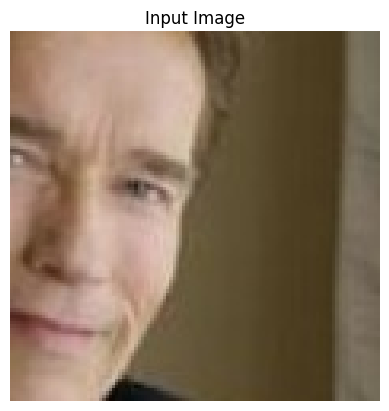

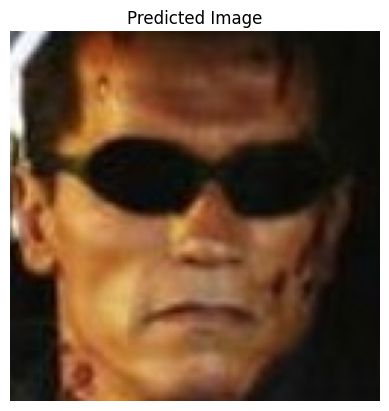

In [143]:
input_image_path = "test/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0003_3.jpg"
input_image = Image.open(input_image_path)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis('off')
plt.show()

predicted_path = compare_faces(input_image, inference_images, embeddings, labels, images, image_threshold=0.90, folder_threshold=0.90)

if predicted_path is not None:
    predicted_image = Image.open(predicted_path)
    plt.imshow(predicted_image)
    plt.title("Predicted Image")
    plt.axis('off')
    plt.show()
else:
    print("No matching person found.")

In [59]:
torch.save(model, 'face_recognition.pt')

In [10]:
model = torch.load('model.pt')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Define the true labels and predicted labels
true_labels = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
predicted_labels = np.array([0, 1, 1, 0, 1, 2, 0, 2, 2])

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

TODO: 
- get a better model 
- evaluation metrics
- setup testing on a single input  

## API Stuff with FLASK


In [ ]:
 !pip install flask flask_cors

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.6:5000
Press CTRL+C to quit
192.168.1.6 - - [15/May/2024 09:24:42] "GET /upload HTTP/1.1" 200 -


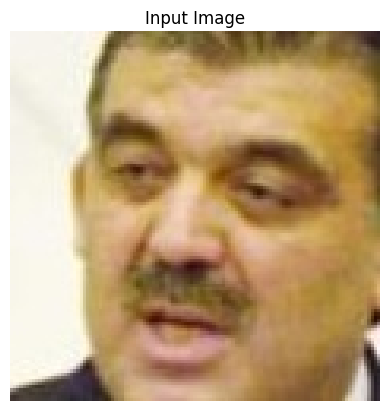

192.168.1.6 - - [15/May/2024 09:24:48] "POST /upload HTTP/1.1" 200 -
192.168.1.6 - - [15/May/2024 09:24:48] "GET /static/Abdullah_Gul_0001_2.jpg HTTP/1.1" 200 -


In [153]:
from PIL import Image
from flask import Flask, request, jsonify
from flask_cors import CORS
import os
import cv2

def getPrediction(filename):   
    img_path = 'static/' + filename
    input_image = Image.open(img_path)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    predicted_path = compare_faces(input_image, inference_images, embeddings, labels, images, image_threshold=0.90, folder_threshold=0.90)

    if predicted_path is not None:
        predicted_image = Image.open(predicted_path)
        plt.imshow(predicted_image)
        plt.title("Predicted Image")
        plt.axis('off')
        plt.show()
        return predicted_path
    else:
        return "No matching person found."

app = Flask(__name__)
CORS(app)

UPLOAD_FOLDER = 'static'
app.secret_key = "secret key"
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)


# For test only
@app.route('/upload', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        # Check if the post request has the file part
        if 'file' not in request.files:
            return jsonify({'message': 'No file part'}), 400
        file = request.files['file']
        # If the user does not select a file, the browser submits an
        # empty file without a filename.
        if file.filename == '':
            return jsonify({'message': 'No selected file'}), 400
        if file:
            filename = file.filename
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            label = getPrediction(filename)  # Assuming getPrediction takes filename and handles full path internally
            return jsonify({'message': str(label), 'image': "/" + filename}), 200
            
    # If it's a GET request, show the upload form
    return '''
    <!doctype html>
    <title>Upload new File</title>
    <h1>Upload new File</h1>
    <form method=post enctype=multipart/form-data>
    <input type="file" accept="image/*" capture="camera" name="file">
      <input type=submit value=Upload>
    </form>
    '''

# For production
@app.route('/static', methods=['POST', 'GET'])
def submit_file():
    if request.method == 'POST':
        if 'file' not in request.files:
            return jsonify({'message': 'No file part'}), 400
        file = request.files['file']
        if file.filename == '':
            return jsonify({'message': 'No selected file'}), 400
        if file:
            filename = file.filename
            file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
            full_filename = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            label = getPrediction(filename)
            return jsonify({'message': str(label), 'image': "/" + filename}), 200

@app.route('/', methods=['GET'])
def load():
    return 'Hello world', 200

if __name__ == "__main__":
    app.run(host='0.0.0.0', port=5000)